Let's analyze the publicly available data about the Art Institute of Chicago's collection. Maybe there's some cool shit idk

In [34]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt 
import textwrap
from PIL import Image
from io import BytesIO
import random
import sys
from pathlib import Path
from dataclasses import dataclass 
from typing import Any, Optional, List, Dict 
import seaborn as sns 

In [13]:
project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.processing import ArtworkJSONProcessor

In [19]:
aic = pd.read_json('allArtworks.jsonl', lines = True)
aic.head(10)

/var/folders/yh/5wvljhq970bfz27txd29qqcw0000gn/T/ipykernel_81858/2826104785.py:1: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  aic = pd.read_json('allArtworks.jsonl', lines = True)


ValueError: Expected object or value

In [20]:
processor = ArtworkJSONProcessor()
full_aic = processor.process_artwork_jsons()

Processing JSON files:   0%|          | 0/132777 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Processing JSON files: 100%|██████████| 132777/132777 [00:09<00:00, 13500.25it/s]


Let's start by understanding some basic facts about the size and scale of AIC's collection 

In [ ]:
aic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132769 entries, 0 to 132768
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   id                     132769 non-null  int64 
 1   title                  132768 non-null  object
 2   main_reference_number  132769 non-null  object
 3   department_title       126212 non-null  object
 4   artist_title           114074 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.1+ MB


In [ ]:
unique_artists = aic['artist_title'].unique()
depts = aic['department_title'].unique()

print(f"{len(unique_artists)} different artists")
print(f"{len(depts)} different departments ")


13967 different artists
16 different departments 


Let's take a look at all the different departments to see how art is categorized. 

In [ ]:
print(depts)

['Prints and Drawings' 'Arts of the Americas' 'Arts of Asia'
 'Applied Arts of Europe'
 'Arts of the Ancient Mediterranean and Byzantium' None 'Textiles'
 'Arts of Africa' 'Painting and Sculpture of Europe' 'Modern Art'
 'Photography and Media' 'Contemporary Art' 'Architecture and Design'
 'Modern and Contemporary Art'
 'Ryerson and Burnham Libraries Special Collections' 'AIC Archives']


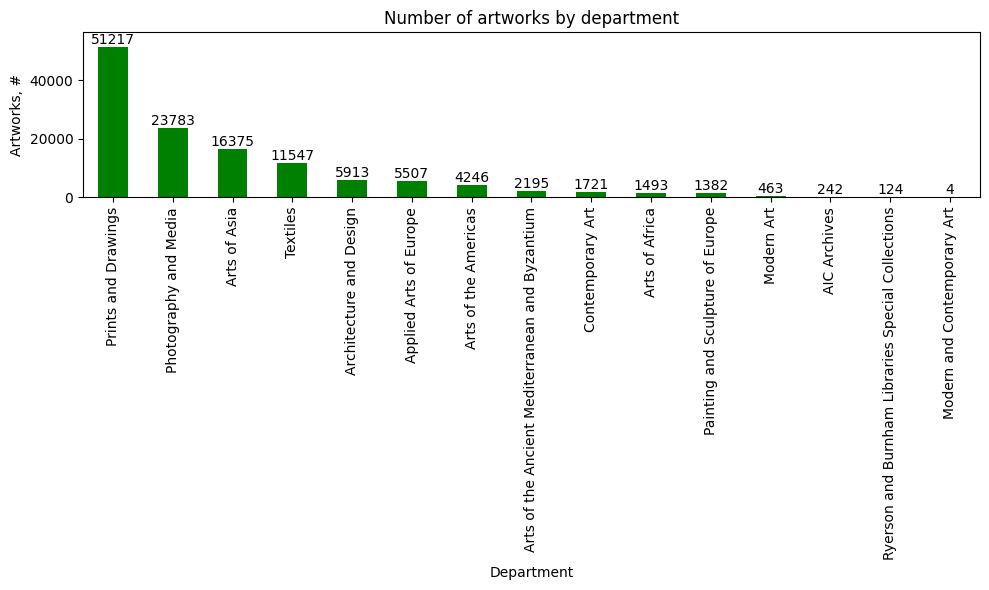

In [ ]:
dept_counts = aic['department_title'].value_counts()

#Make plot
plt.figure(figsize= (10, 6))
bars = dept_counts.plot(kind= 'bar', color = 'green') #Create bar chart 
plt.title("Number of artworks by department")
plt.xlabel('Department')
plt.ylabel('Artworks, #')

# wrapped_labels = [textwrap.fill(label, width=10) for label in dept_counts.index]
# plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels)

#Add counts on top of each bar
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate of the text
        bar.get_height(),                     # y-coordinate of the text
        int(bar.get_height()),                # text value
        ha='center',                          # horizontal alignment
        va='bottom'                           # vertical alignment
    )
plt.ylim(0, dept_counts.max() * 1.1)

plt.tight_layout()
plt.show()


It's interesting that there are only 4 artworks categorized as 'Modern and Contemporary'. Especially since there is an entire wing dedicated to that type of art. I'm curious as to what they are, and since there are only 4 we can try to render them using AIC's api.

In [ ]:
modern_ids = aic[aic['department_title'] == 'Modern and Contemporary Art']['id']
print(modern_ids)


74585     124828
128547    260096
129669    263729
130307    265984
Name: id, dtype: int64


In [ ]:
def generate_image(aic_id):
    aic_id = str(aic_id)
    metadata_url = f"https://api.artic.edu/api/v1/artworks/{aic_id}"
    metadata_response = requests.get(metadata_url).json()

    # Check if 'data' and 'image_id' keys are in the response
    if 'data' not in metadata_response or 'image_id' not in metadata_response['data']:
        print(f"Metadata for ID {aic_id} is missing 'image_id'.")
        return None

    # Extract the identifier for the image
    image_id = metadata_response['data']['image_id']
    image_url = f"https://www.artic.edu/iiif/2/{aic_id}/full/843,/0/default.jpg"
    
    # Request the image and check for a successful response
    image_response = requests.get(image_url)
    if image_response.status_code != 200:
        print(f"Image for ID {aic_id} could not be retrieved (status code {image_response.status_code}).")
        return None
    
    # Try to open the image
    try:
        image = Image.open(BytesIO(image_response.content))
    except Exception as e:
        print(f"Error opening image for ID {aic_id}: {e}")
        return None
    
    return image

In [ ]:
generate_image(129884)

Image for ID 129884 could not be retrieved (status code 404).


In [ ]:
def get_details(aic_id):
    # Ensure aic_id is a string
    aic_id = str(aic_id)
    
    # Filter DataFrame for matching id, ensuring both sides are strings for comparison
    match = aic[aic['id'].astype(str) == aic_id]
    
    # Check if any matches are found
    if match.empty:
        print(f"No details found for ID {aic_id}")
        return None, None
    
    # Extract title and artist_name if match is found
    title = match['title'].values[0]
    artist = match['artist_title'].values[0]
    
    return title, artist
   
print(get_details(129884)) 

('Starry Night and the Astronauts', 'Alma Thomas')


In [ ]:
for id in modern_ids: 
    print(get_details(id))
    

('Baby Steps from the Cave', 'William T. Wiley')
('Epping II', 'Igshaan Adams')
('Woman Leaning on Her Elbow: Portrait of Katalin Dávid (Könyökére támaszkodó nö: Dávid Katalin portréja)', 'Béla Kondor')
('10/29/52', 'Helen Frankenthaler')


In [ ]:
artist_dept_counts = aic.groupby(['artist_title', 'department_title']).size().reset_index(name= 'count')
artist_totals = artist_dept_counts.groupby('artist_title')['count'].sum().reset_index(name='total_works')
artist_dept_summary = artist_dept_counts.merge(artist_totals, on='artist_title')
artist_dept_summary = artist_dept_summary.sort_values(by='total_works', ascending=False)

artist_dept_summary.head(10)



,artist_title,department_title,count,total_works
14000,Utagawa Hiroshige,Arts of Asia,1594,1595
13999,Utagawa Hiroshige,Arts of Africa,1,1595
13940,Unknown,Photography and Media,992,1165
13937,Unknown,Applied Arts of Europe,1,1165
13938,Unknown,Architecture and Design,5,1165
13941,Unknown,Prints and Drawings,158,1165
13939,Unknown,Arts of the Americas,2,1165
13942,Unknown,Textiles,7,1165
13956,Unknown Maker,Photography and Media,1159,1159
633,Ancient Roman,Arts of Asia,1,1139


In [ ]:
artist_dept_pivot = artist_dept_summary.pivot(index= 'artist_title', columns= 'department_title', values= 'count')
artist_dept_pivot = artist_dept_pivot.fillna(0)
artist_dept_pivot['total_works'] = artist_dept_pivot.sum(axis= 1)
artist_dept_pivot = artist_dept_pivot.sort_values(by='total_works', ascending=False)
total_works = artist_dept_pivot['total_works'].sum()
artist_dept_pivot['pct_of_total'] = (artist_dept_pivot['total_works'] / total_works) * 100
artist_dept_pivot['pct_of_total'] = artist_dept_pivot['pct_of_total'].map("{:.2f}%".format)
artist_dept_pivot



department_title,AIC Archives,Applied Arts of Europe,Architecture and Design,Arts of Africa,Arts of Asia,Arts of the Americas,Arts of the Ancient Mediterranean and Byzantium,Contemporary Art,Modern Art,Modern and Contemporary Art,Painting and Sculpture of Europe,Photography and Media,Prints and Drawings,Ryerson and Burnham Libraries Special Collections,Textiles,total_works,pct_of_total
artist_title,,,,,,,,,,,,,,,,,
Utagawa Hiroshige,0.0,0.0,0.0,1.0,1594.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1595.0,1.46%
Unknown,0.0,1.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,992.0,158.0,0.0,7.0,1165.0,1.06%
Unknown Maker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1159.0,0.0,0.0,0.0,1159.0,1.06%
Ancient Roman,0.0,0.0,0.0,8.0,1.0,0.0,1130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1139.0,1.04%
James McNeill Whistler,1.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1085.0,0.0,0.0,1096.0,1.00%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
James Sharples,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.00%
James Seymour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.00%
James Roy Hopkins,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00%


No artist has more than ~1.5% of the entire collection. And the artist with the most works in the AIC's collection is 'Utagawa Hiroshige'. Who woulda thunk it!

Let's do something completely differnet. Like create a function that returns a random artwork from the collection, kind of like the AIC chrome browser extension. 

In [ ]:
upper_lim = aic['id'].max() 

def random_art(max_attempts=100):  # Optional parameter to limit attempts
    attempts = 0
    
    while attempts < max_attempts:
        rand_id = random.randint(1, upper_lim)
        attempts += 1
        
        try:
            # Get details for the artwork
            title, artist = get_details(rand_id)
            if title is None or artist is None:
                print(f"No details found for ID {rand_id}. Trying another ID...")
                continue  # Try another random ID
            
            # Generate the image
            image = generate_image(rand_id)
            if image is None:
                print(f"Metadata for ID {rand_id} is missing 'image_id'. Trying another ID...")
                continue  # Try another random ID
            
            # Create a plot
            fig, ax = plt.subplots()
            
            # Display the image
            ax.imshow(image)
            ax.axis('off')  # Hide axes

            # Add the title using artwork title and artist name
            plt.title(f"{title} by {artist}", fontsize=14, pad=20)

            # Show the plot with the image and title
            plt.show()
            return  # Exit the function after successful display

        except TypeError as e:
            # print(f"TypeError encountered for ID {rand_id}: {e}")
            continue
        except Exception as e:
            # print(f"An unexpected error occurred for ID {rand_id}: {e}")
            continue

    print("Max attempts reached. No valid artwork found.")


In [ ]:
random_art()

Image for ID 209196 could not be retrieved (status code 404).
Metadata for ID 209196 is missing 'image_id'. Trying another ID...
No details found for ID 241733
No details found for ID 241733. Trying another ID...
Image for ID 32123 could not be retrieved (status code 404).
Metadata for ID 32123 is missing 'image_id'. Trying another ID...
Image for ID 233964 could not be retrieved (status code 404).
Metadata for ID 233964 is missing 'image_id'. Trying another ID...
No details found for ID 65393
No details found for ID 65393. Trying another ID...
Image for ID 67863 could not be retrieved (status code 404).
Metadata for ID 67863 is missing 'image_id'. Trying another ID...
Image for ID 91589 could not be retrieved (status code 404).
Metadata for ID 91589 is missing 'image_id'. Trying another ID...
No details found for ID 97932
No details found for ID 97932. Trying another ID...
No details found for ID 96623. Trying another ID...
Image for ID 84244 could not be retrieved (status code 404).


KeyboardInterrupt: 

In [ ]:
generate_image(129884)

Image for ID 129884 could not be retrieved (status code 404).


Full_aic is a dataframe that has all the information related to artworks in the AIC collection. 

In [21]:
full_aic.head(10)
full_aic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132777 entries, 0 to 132776
Data columns (total 98 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             132777 non-null  int64  
 1   api_model                      132777 non-null  object 
 2   api_link                       132777 non-null  object 
 3   is_boosted                     132777 non-null  bool   
 4   title                          132776 non-null  object 
 5   alt_titles                     1800 non-null    object 
 6   thumbnail                      118915 non-null  object 
 7   main_reference_number          132777 non-null  object 
 8   has_not_been_viewed_much       132777 non-null  bool   
 9   boost_rank                     20 non-null      float64
 10  date_start                     127725 non-null  float64
 11  date_end                       127725 non-null  float64
 12  date_display                  

In [ ]:
for i, col in enumerate(full_aic.columns, 1):
    print(f"{i:2d}. {col}")

 1. id
 2. api_model
 3. api_link
 4. is_boosted
 5. title
 6. alt_titles
 7. thumbnail
 8. main_reference_number
 9. has_not_been_viewed_much
10. boost_rank
11. date_start
12. date_end
13. date_display
14. date_qualifier_title
15. date_qualifier_id
16. artist_display
17. place_of_origin
18. description
19. short_description
20. dimensions
21. dimensions_detail
22. medium_display
23. inscriptions
24. credit_line
25. catalogue_display
26. publication_history
27. exhibition_history
28. provenance_text
29. edition
30. publishing_verification_level
31. internal_department_id
32. fiscal_year
33. fiscal_year_deaccession
34. is_public_domain
35. is_zoomable
36. max_zoom_window_size
37. copyright_notice
38. has_multimedia_resources
39. has_educational_resources
40. has_advanced_imaging
41. colorfulness
42. color
43. latitude
44. longitude
45. latlon
46. is_on_view
47. on_loan_display
48. gallery_title
49. gallery_id
50. artwork_type_title
51. artwork_type_id
52. department_title
53. department

Filtering down dataset to only focus on images in the public domain that will likely make it into app. Let's also figure out which images have good dimensions for various screen types (e.g., iPhone, TV, etc.)  

In [22]:
def filter_public_domain(df, verbose = True): 
    '''Filter data frame to only include public works'''

    if verbose:
        print("Original dataset:")
        print(f"Total records: {len(df):,}")
        print("\nPublic domain status:")
        print(df['is_public_domain'].value_counts(dropna=False))

    # Filter for public domain works
    public_df = df[
        df['is_public_domain'].fillna(False) == True
    ].reset_index(drop=True)

    if verbose:
        print(f"\nAfter filtering:")
        print(f"Public domain records: {len(public_df):,}")
        print(f"Percentage public domain: {(len(public_df) / len(df) * 100):.1f}%")

    # Verify filter worked
    assert public_df['is_public_domain'].all(), "Found non-public domain works!"

    return public_df

aic_public = filter_public_domain(full_aic)

Original dataset:
Total records: 132,777

Public domain status:
is_public_domain
False    73049
True     59728
Name: count, dtype: int64

After filtering:
Public domain records: 59,728
Percentage public domain: 45.0%


In [23]:
# Basic value counts for each column
print("Artwork Types:")
print(aic_public['artwork_type_title'].value_counts().head(10))

print("\nDepartments:")
print(aic_public['department_title'].value_counts())

print("\nStyles:")
print(aic_public['style_title'].value_counts().head(10))

Artwork Types:
artwork_type_title
Print                      23987
Drawing and Watercolor      8295
Textile                     5905
Photograph                  4190
Vessel                      2639
Costume and Accessories     1907
Painting                    1817
Glass                       1774
Ceramics                    1665
Sculpture                   1257
Name: count, dtype: int64

Departments:
department_title
Prints and Drawings                                  25811
Arts of Asia                                         10167
Textiles                                              7036
Applied Arts of Europe                                4971
Photography and Media                                 4192
Arts of the Americas                                  2827
Arts of the Ancient Mediterranean and Byzantium       2054
Painting and Sculpture of Europe                      1266
Arts of Africa                                        1073
Architecture and Design                         

In [24]:
@dataclass
class DisplayDevice:
    '''
    Holds data on display device specifications
    '''
    name: str
    width: int
    height: int
    min_dpi: int #Lower bound for good quality display

    @property
    def aspect_ratio(self) -> float: 
        return self.width / self.height
    
    @property
    def resolution(self) -> float: 
        return self.width * self.height
    
DISPLAY_DEVICES = {
'iPhone 14': DisplayDevice('iPhone 14', 1170, 2532, 460),
'iPhone 14 Plus': DisplayDevice('iPhone 14 Plus', 1284, 2778, 458),
'iPad Pro 12.9': DisplayDevice('iPad Pro 12.9', 2048, 2732, 264),
'MacBook Pro 14': DisplayDevice('MacBook Pro 14', 3024, 1964, 254),
'MacBook Pro 16': DisplayDevice('MacBook Pro 16', 3456, 2234, 254),
'HD TV': DisplayDevice('HD TV', 1920, 1080, 40),
'4K TV': DisplayDevice('4K TV', 3840, 2160, 80),
'Instagram Square': DisplayDevice('Instagram Square', 1080, 1080, 150),
'Instagram Portrait': DisplayDevice('Instagram Portrait', 1080, 1350, 150),
'Instagram Landscape': DisplayDevice('Instagram Landscape', 1080, 608, 150),
}

In [31]:
def calc_display_compatability(df: pd.DataFrame) -> pd.DataFrame:
    '''Analyze artwork dimensions for compatability with various screens'''
    
    def get_dimensions(dims_detail: List[Dict]) -> tuple: 
        try:
            if not isinstance(dims_detail, list) or not dims_detail: 
                return None, None
            
            dims = dims_detail[0]
            height = dims.get('height')
            width = dims.get('width')
            
            if not height or not width or height <=0 or width <= 0: 
                return None, None
            
            return float(height), float(width)
        except Exception: 
            return None, None
    
    def analyze_compatability(dims_detail: List[Dict]) -> Dict:
        height, width = get_dimensions(dims_detail)
        if height is None or width is None: 
            return {
                'display_orientation': None, 
                'aspect_ratio': None, 
                'best_displays': [],
                'compatability_scores': {},
                'display_recommendations': []
            }
        
        artwork_ratio = width / height
        
        scores = {}
        for device_name, device in DISPLAY_DEVICES.items():
            ratio_diff = abs(artwork_ratio - device.aspect_ratio)
            ratio_score = 1 / (1 + ratio_diff)
            
            #Resolution compatability
            artwork_pixels = height * width
            resolution_ratio = min(artwork_pixels / device.resolution, 1)
            
            #Weighted score combining resolution and aspect ratio 
            scores[device_name] = 0.9 * ratio_score + 0.1 * resolution_ratio
        
        best_displays = [device for device, score in scores.items() if score > 0.8]
        
        recommendations = []
        if artwork_ratio > 1.2: 
            recommendations.append("Landscape")
            display_orientation = 'Landscape'
        elif artwork_ratio < 0.8: 
            recommendations.append("Portrait")
            display_orientation = 'Portrait'
        else: 
            recommendations.append("Square-ish")
            display_orientation = 'Square'
        
        if not best_displays: 
            recommendations.append('May need re-sizing for optimal display')
        
        return {
            'display_orientation': display_orientation,
            'aspect_ratio': round(artwork_ratio, 3),
            'best_displays': best_displays,
            'compatability_scores': scores,
            'display_recommendations': recommendations
        }        
    
    #Apply analysis to artwork 
    compatability_data = df['dimensions_detail'].apply(analyze_compatability)
    
    df['display_orientation'] = compatability_data.apply(lambda x: x['display_orientation'])
    df['aspect_ratio'] = compatability_data.apply(lambda x: x['aspect_ratio'])
    df['best_displays'] = compatability_data.apply(lambda x: x['best_displays'])
    df['display_recommendations'] = compatability_data.apply(lambda x: x['display_recommendations'])
    
    #Add individual compatability scores as cols 
    for device in DISPLAY_DEVICES.keys():
        df[f'{device}_compatability'] = compatability_data.apply(lambda x: x['compatability_scores'].get(device, 0))
    
    return df 

In [32]:
aic_public = calc_display_compatability(aic_public)

In [27]:
def analyze_display_compatability(df: pd.DataFrame) -> None:
    """
    Print analysis of display compatability across the dataset.
    
    Args:
    df: DataFrame with display compatability columns
    """

    print("Display Compatability Analysis")
    print("-" * 50)

    # Overall orientation distribution
    print("\nOrientation Distribution:")
    orientation_counts = df['display_orientation'].value_counts()
    for orientation, count in orientation_counts.items():
        percentage = (count / len(df)) * 100
        print(f"{orientation:<10}: {count:5,d} ({percentage:5.1f}%)")

    # Device compatability analysis
    print("\nDevice Compatability (works well with):")
    for device in DISPLAY_DEVICES.keys():
        good_matches = (df[f'{device}_compatability'] > 0.8).sum()
        percentage = (good_matches / len(df)) * 100
        print(f"{device:<15}: {good_matches:5,d} ({percentage:5.1f}%)")

    # Visualization
    plt.figure(figsize=(12, 6))
    compatability_means = df[[f'{device}_compatability' 
                            for device in DISPLAY_DEVICES.keys()]].mean()

    sns.barplot(x=compatability_means.index, y=compatability_means.values)
    plt.xticks(rotation=45, ha='right')
    plt.title('Average Compatability Scores by Display Device')
    plt.tight_layout()
    plt.show()



Display Compatability Analysis
--------------------------------------------------

Orientation Distribution:
Portrait  : 20,562 ( 34.4%)
Landscape : 15,687 ( 26.3%)
Square    : 8,407 ( 14.1%)

Device Compatability (works well with):
iPhone 14      : 4,357 (  7.3%)
iPhone 14 Plus : 4,355 (  7.3%)
iPad Pro 12.9  : 16,721 ( 28.0%)
MacBook Pro 14 : 5,792 (  9.7%)
MacBook Pro 16 : 5,787 (  9.7%)
HD TV          : 1,361 (  2.3%)
4K TV          : 1,358 (  2.3%)
Instagram Square: 4,242 (  7.1%)
Instagram Portrait: 14,586 ( 24.4%)
Instagram Landscape: 1,365 (  2.3%)


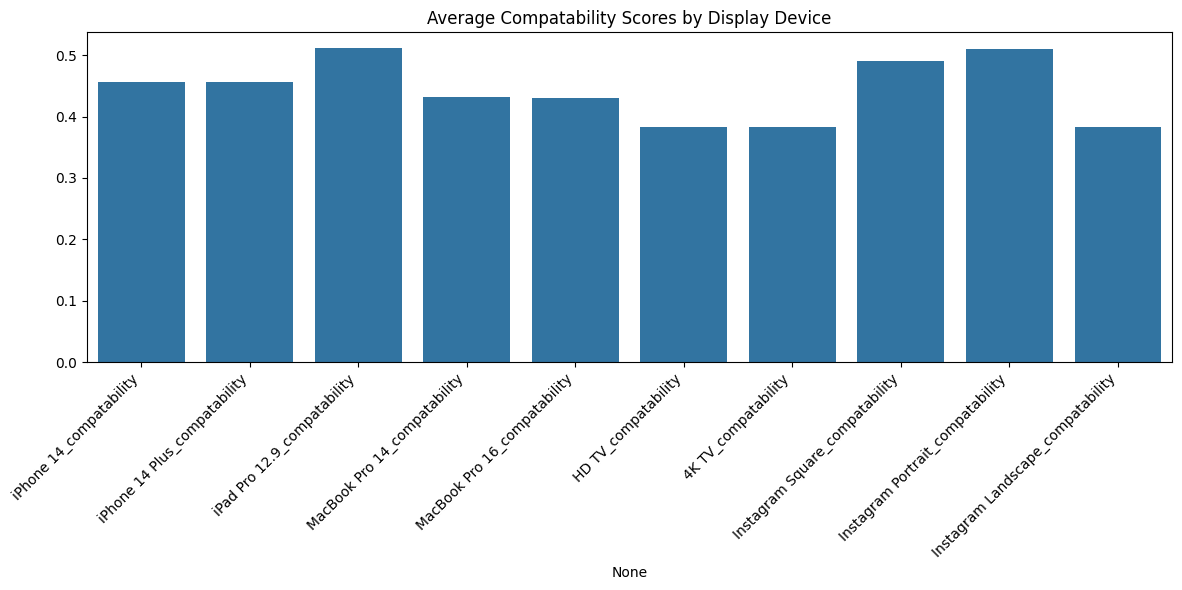

In [35]:
analyze_display_compatability(aic_public)